# Multiclass with GWAS

## Init

In [ ]:
# -------------------------
# SECTION 0 — PREAMBLE / INSTALL
# -------------------------
import os
try:
    import torch
    import pyfaidx
except ImportError:
    print("Installing dependencies...")
    !pip install -q transformers[torch] accelerate scikit-learn pandas pyfaidx matplotlib

# -------------------------
# SECTION 1 — IMPORTS
# -------------------------
import re
import gc
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyfaidx import Fasta
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, average_precision_score, roc_auc_score,
    roc_curve, precision_recall_curve, auc
)
import torch
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

## Download

In [ ]:
# -------------------------
# SECTION 2 — DOWNLOAD ClinVar + hg38 + GWAS CATALOG
# -------------------------
# ClinVar
if not os.path.exists("variant_summary.txt.gz"):
    print("Downloading ClinVar variant_summary.txt.gz ...")
    !wget -q https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz

# hg38 fasta
if not os.path.exists("hg38.fa"):
    print("Downloading hg38.fa.gz ...")
    !wget -q -O hg38.fa.gz https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
    !gunzip -f hg38.fa.gz

# GWAS Catalog (example release filename; will download latest if not present)
GWAS_FILE = "gwas_catalog_v1.0.2-associations_e104_r2024-04-25.tsv"

In [ ]:
import requests
import zipfile
import io

def download_gwas_v1(dest="gwas_v1_associations.tsv"):
    url = "https://www.ebi.ac.uk/gwas/api/search/downloads/associations/v1.0?split=false"

    print("Downloading GWAS v1.0 associations (ZIP archive)...")
    r = requests.get(url, stream=True, timeout=120)

    if r.status_code != 200:
        raise RuntimeError(f"Download failed: HTTP {r.status_code}")

    # Load zip in memory
    z = zipfile.ZipFile(io.BytesIO(r.content))

    # Find tsv file inside zip
    tsv_files = [f for f in z.namelist() if f.endswith(".tsv")]

    if not tsv_files:
        raise RuntimeError("ZIP contains no TSV files.")

    # Usually the first one
    tsv_file = tsv_files[0]
    print("Found inside ZIP:", tsv_file)

    # Extract to disk
    with z.open(tsv_file) as f_in, open(dest, "wb") as f_out:
        f_out.write(f_in.read())

    print("Saved extracted TSV to:", dest)
    return dest

# Run
GWAS_FILE = download_gwas_v1("gwas_v1_associations.tsv")


Found inside ZIP: gwas-catalog-download-associations-v1.0-full.tsv
Saved extracted TSV to: gwas_v1_associations.tsv


## Construct dataset

In [ ]:
# -------------------------
# SECTION 3 — LOAD & CLEAN ClinVar
# -------------------------
print("\n--- LOAD & CLEAN ClinVar ---")

subset_cols = [
    "Chromosome", "PositionVCF", "Start",
    "ReferenceAlleleVCF", "AlternateAlleleVCF",
    "ReferenceAllele", "AlternateAllele",
    "GeneSymbol", "ClinicalSignificance", "PhenotypeList",
    "Assembly", "Origin", "Type"
]

df = pd.read_csv(
    "variant_summary.txt.gz",
    sep="\t",
    compression="gzip",
    low_memory=False,
    usecols=lambda c: c in subset_cols
)

# Filter GRCh38 + germline + SNV
df = df[
    (df["Assembly"] == "GRCh38") &
    (df["Origin"].str.contains("germline", na=False)) &
    (df["Type"] == "single nucleotide variant")
].copy()

# Coalesce positions
df["final_pos"] = df["PositionVCF"]
mask_bad_pos = df["final_pos"].isna() | (df["final_pos"] == -1)
df.loc[mask_bad_pos, "final_pos"] = df.loc[mask_bad_pos, "Start"]

# Coalesce ref/alt
df["Ref"] = df["ReferenceAlleleVCF"].copy()
df["Alt"] = df["AlternateAlleleVCF"].copy()
for col in ["Ref", "Alt"]:
    df.loc[df[col].astype(str).str.lower() == "na", col] = np.nan
df["Ref"] = df["Ref"].fillna(df["ReferenceAllele"])
df["Alt"] = df["Alt"].fillna(df["AlternateAllele"])

# Drop unusable rows
df = df.dropna(subset=["Chromosome", "final_pos", "Ref", "Alt"])
df["Chromosome"] = df["Chromosome"].astype(str)
df = df[df["Ref"].str.len() == 1]
df = df[df["Alt"].str.len() == 1]

print(f"ClinVar usable SNVs: {len(df):,}")


--- LOAD & CLEAN ClinVar ---
ClinVar usable SNVs: 3,553,852


In [ ]:
# -------------------------
# SECTION 4 — DEFINE DISORDERS (ClinVar keywords) & GWAS keywords
# -------------------------
disorder_keywords = {
    "ASD":     r"autism|autistic|pervasive developmental|asd",
    "ADHD":    r"adhd|attention deficit|hyperactivity",
    "BIPOLAR": r"bipolar|mania|manic",
    "SCZ":     r"schizo|psychosis|psychotic"
}

gwas_keywords = {
    "ASD":     ["autism", "autistic", "pervasive developmental"],
    "ADHD":    ["adhd", "attention deficit"],
    "BIPOLAR": ["bipolar", "manic"],
    "SCZ":     ["schizophrenia"],
    "MDD":     ["depression", "major depressive"],
    "ANXIETY": ["anxiety", "panic disorder"],
    "OCD":     ["obsessive compulsive"],
    "TOURETTE":["tourette"]
}

In [ ]:
# -------------------------
# SECTION 5 — ANNOTATE ClinVar with disorder presence (binary)
# -------------------------
print("\n--- ANNOTATING ClinVar with phenotype keywords ---")

def extract_disorder_labels(row, keywords_map):
    pheno = str(row.get("PhenotypeList", "")).lower()
    return pd.Series([1 if re.search(pat, pheno) else 0 for pat in keywords_map.values()],
                     index=keywords_map.keys())

clinvar_labels = df.apply(lambda r: extract_disorder_labels(r, disorder_keywords), axis=1)
clinvar_labels = clinvar_labels.astype(int)
df = pd.concat([df.reset_index(drop=True), clinvar_labels.reset_index(drop=True)], axis=1)

# Keep rows that have at least one phenotype (either one of our keywords)
df = df[df[list(disorder_keywords.keys())].sum(axis=1) > 0]
print(f"ClinVar rows with target disorder keywords: {len(df):,}")


--- ANNOTATING ClinVar with phenotype keywords ---
ClinVar rows with target disorder keywords: 1,991


In [ ]:
# -------------------------
# SECTION 6 — LOAD & FILTER GWAS CATALOG FOR NEUROPSYCHIATRIC TRAITS
# -------------------------
print("\n--- LOADING & FILTERING GWAS CATALOG ---")
gwas_df = pd.read_csv(GWAS_FILE, sep="\t", low_memory=False)

# Normalize CHR/POS columns presence
# The GWAS catalog uses columns: 'CHR_ID', 'CHR_POS', 'DISEASE/TRAIT', 'P-VALUE'
for col in ["CHR_ID", "CHR_POS", "DISEASE/TRAIT", "P-VALUE"]:
    if col not in gwas_df.columns:
        raise RuntimeError(f"Expected GWAS column '{col}' not found in GWAS file")

# Build mask for neuropsychiatric traits
mask = np.zeros(len(gwas_df), dtype=bool)
for trait, keywords in gwas_keywords.items():
    for w in keywords:
        mask |= gwas_df["DISEASE/TRAIT"].str.contains(w, case=False, na=False)

gwas_np_df = gwas_df[mask].copy()
print(f"GWAS neuropsychiatric rows: {len(gwas_np_df):,}")


--- LOADING & FILTERING GWAS CATALOG ---
GWAS neuropsychiatric rows: 14,370


In [ ]:
# -------------------------
# SECTION 7 — HARMONIZE GWAS: make pos_key and compute risk scores
# -------------------------
print("\n--- HARMONIZING GWAS ---")

def parse_gwas_pos(row):
    try:
        chr_id = str(row["CHR_ID"]).replace("chr", "").strip()
        pos = int(row["CHR_POS"])
        # normalize mitochondrial notation
        if chr_id in ("MT", "M"): chr_id = "M"
        return f"{chr_id}:{pos}"
    except:
        return None

gwas_np_df["pos_key"] = gwas_np_df.apply(parse_gwas_pos, axis=1)

# p-values -> numeric, convert any scientific notation strings
gwas_np_df["pval"] = pd.to_numeric(gwas_np_df["P-VALUE"], errors="coerce")
# Replace pval<=0 with small epsilon to avoid -log10(0)
gwas_np_df.loc[gwas_np_df["pval"] <= 0, "pval"] = np.nan
# -log10(pval)
gwas_np_df["gwas_score_raw"] = -np.log10(gwas_np_df["pval"])
# Replace infinite/NaN with 0
gwas_np_df["gwas_score_raw"] = gwas_np_df["gwas_score_raw"].replace([np.inf, -np.inf], np.nan).fillna(0.0)

# Normalize per-catalog to [0,1]
max_raw = gwas_np_df["gwas_score_raw"].max()
if max_raw <= 0:
    gwas_np_df["gwas_score"] = 0.0
else:
    gwas_np_df["gwas_score"] = (gwas_np_df["gwas_score_raw"] / max_raw).clip(0, 1)

# For convenience, group by pos_key and keep max score (strongest association)
gwas_pos_to_maxscore = gwas_np_df.groupby("pos_key")["gwas_score"].max().to_dict()

print(f"Unique GWAS positions (after parsing): {len(gwas_pos_to_maxscore):,}")



--- HARMONIZING GWAS ---
Unique GWAS positions (after parsing): 10,696


In [ ]:
# -------------------------
# SECTION 8 — CREATE PER-DISORDER GWAS SIGNALS
# -------------------------
print("\n--- CREATING PER-DISORDER GWAS SIGNALS ---")
# Build a dictionary mapping disorder -> set of pos_key that match that disorder in GWAS
gwas_disorder_pos = {}
for disorder, kws in gwas_keywords.items():
    mask = np.zeros(len(gwas_np_df), dtype=bool)
    for w in kws:
        mask |= gwas_np_df["DISEASE/TRAIT"].str.contains(w, case=False, na=False)
    pos_keys = set(gwas_np_df[mask]["pos_key"].dropna().unique().tolist())
    gwas_disorder_pos[disorder] = pos_keys
    print(f"{disorder}: {len(pos_keys):,} unique GWAS positions")

# Map ClinVar rows to GWAS signals per disorder
def map_gwas_signal(chr_str, pos):
    key = f"{str(chr_str).replace('chr','').strip()}:{int(pos)}"
    return gwas_pos_to_maxscore.get(key, 0.0)

for disorder in gwas_keywords.keys():
    col = f"GWAS_{disorder}"
    df[col] = df.apply(lambda r: gwas_pos_to_maxscore.get(f"{str(r['Chromosome']).replace('chr','').strip()}:{int(r['final_pos'])}", 0.0), axis=1)



--- CREATING PER-DISORDER GWAS SIGNALS ---
ASD: 1,221 unique GWAS positions
ADHD: 1,552 unique GWAS positions
BIPOLAR: 1,602 unique GWAS positions
SCZ: 4,578 unique GWAS positions
MDD: 3,645 unique GWAS positions
ANXIETY: 583 unique GWAS positions
OCD: 111 unique GWAS positions
TOURETTE: 218 unique GWAS positions


In [ ]:
# -------------------------
# SECTION 9 — MERGE ClinVar + GWAS (Complementary Union)
# -------------------------
print("\n--- MERGING CLINVAR + GWAS (Complementary Union) ---")

# Use disorders from gwas_keywords
disorders = list(gwas_keywords.keys())
label_cols = [f"LABEL_{d}" for d in disorders]

# --- ClinVar: add missing LABEL_* columns
for col in label_cols:
    if col not in df.columns:
        df[col] = 0

# --- GWAS: create LABEL_* columns from gwas_disorder_pos
for d in disorders:
    col = f"LABEL_{d}"
    gwas_np_df[col] = gwas_np_df["pos_key"].apply(lambda x: 1 if x in gwas_disorder_pos.get(d, set()) else 0)

# --- GWAS: remove rows with missing CHR_ID / CHR_POS
gwas_np_df = gwas_np_df.dropna(subset=["CHR_ID","CHR_POS"]).copy()

# --- GWAS: extract first position if multiple semicolon-separated
def parse_first_pos(pos_str):
    try:
        # Some rows have "61366218;61358717;61366266", take first
        return int(str(pos_str).split(";")[0])
    except:
        return np.nan

gwas_np_df["final_pos"] = gwas_np_df["CHR_POS"].apply(parse_first_pos)
# Drop any remaining NaNs
gwas_np_df = gwas_np_df.dropna(subset=["final_pos"])
gwas_np_df["final_pos"] = gwas_np_df["final_pos"].astype(int)

# --- GWAS: Chromosome, REF/ALT
gwas_np_df["Chromosome"] = gwas_np_df["CHR_ID"].astype(str).replace("MT","M")
gwas_np_df["Ref"] = "N"
gwas_np_df["Alt"] = "N"

# --- Mark source
df["SOURCE"] = "clinvar"
gwas_np_df["SOURCE"] = "gwas"

# --- Standardize required columns
required_cols = ["Chromosome", "final_pos", "Ref", "Alt", "SOURCE"] + label_cols

# --- Concatenate datasets
final_df = pd.concat(
    [df[required_cols], gwas_np_df[required_cols]],
    axis=0,
    ignore_index=True
)

print(f"Combined dataset total rows: {len(final_df)}")
print(f"ClinVar rows: {len(df)}")
print(f"GWAS rows: {len(gwas_np_df)}")

# --- Distribution summary
print("\n=== DATASET DISTRIBUTION (POST UNION) ===")
for d in disorders:
    col = f"LABEL_{d}"
    count = final_df[col].sum()
    pct = 100 * count / len(final_df)
    print(f"{d}: {int(count)} samples ({pct:.2f}%), mean_label={final_df[col].mean():.4f}")

# --- Multi-label statistics
multi = (final_df[label_cols].sum(axis=1) > 1).sum()
print(f"\nSamples with >1 positive label: {multi} ({100*multi/len(final_df):.2f}%)")



--- MERGING CLINVAR + GWAS (Complementary Union) ---
Combined dataset total rows: 16132
ClinVar rows: 1991
GWAS rows: 14141

=== DATASET DISTRIBUTION (POST UNION) ===
ASD: 2268 samples (14.06%), mean_label=0.1406
ADHD: 2043 samples (12.66%), mean_label=0.1266
BIPOLAR: 2784 samples (17.26%), mean_label=0.1726
SCZ: 6856 samples (42.50%), mean_label=0.4250
MDD: 5292 samples (32.80%), mean_label=0.3280
ANXIETY: 796 samples (4.93%), mean_label=0.0493
OCD: 123 samples (0.76%), mean_label=0.0076
TOURETTE: 767 samples (4.75%), mean_label=0.0475

Samples with >1 positive label: 3621 (22.45%)


## Sequence extraction

In [ ]:
# -------------------------
# SECTION 10 — SEQUENCE EXTRACTION (from hg38)
# -------------------------
print("\n--- EXTRACTING SEQUENCES FROM hg38 ---")
genome = Fasta("hg38.fa")
CONTEXT_LENGTH = 1000
HALF_CTX = CONTEXT_LENGTH // 2

def get_sequence_mutated(row):
    raw_chrom = str(row["Chromosome"]).replace(".0", "").strip()
    chrom = "chr" + raw_chrom if not raw_chrom.startswith("chr") else raw_chrom
    if raw_chrom in ("MT", "M"): chrom = "chrM"
    if chrom not in genome:
        return None
    try:
        pos = int(row["final_pos"]) - 1
        start = max(0, pos - HALF_CTX)
        end = pos + HALF_CTX
        ref_seq = genome[chrom][start:end].seq.upper()
        if len(ref_seq) != CONTEXT_LENGTH:
            return None
        alt = str(row["Alt"]).upper()
        # If placeholder "N", just use reference base
        if alt == "N":
            alt = ref_seq[pos - start]
        rel = pos - start
        mutated = ref_seq[:rel] + alt + ref_seq[rel+1:]
        if len(mutated) != CONTEXT_LENGTH:
            return None
        return mutated
    except Exception:
        return None

# Apply to merged dataset
final_df["sequence"] = final_df.apply(get_sequence_mutated, axis=1)
final_df = final_df.dropna(subset=["sequence"])
print("Sequences available:", len(final_df))

if len(final_df) == 0:
    raise RuntimeError("No sequences extracted. Check hg38 and positions.")



--- EXTRACTING SEQUENCES FROM hg38 ---
Sequences available: 16116


## Training

In [ ]:
# -------------------------
# SECTION 11 — TRAIN/VALID SPLIT
# -------------------------
print("\n--- SPLIT DATA ---")
X = final_df["sequence"].tolist()
y = final_df[label_cols].values.astype(float)  # shape (N, D)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.10, random_state=0, shuffle=True
)
print("Train samples:", len(X_train), "Val samples:", len(X_val))

# -------------------------
# SECTION 12 — DATASET CLASS
# -------------------------
class GenomicDataset(Dataset):
    def __init__(self, seqs, labels, tokenizer, max_length=512):
        self.seqs = seqs
        self.labels = torch.tensor(labels, dtype=torch.float)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.seqs[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": self.labels[idx]
        }
        return item



--- SPLIT DATA ---
Train samples: 14504 Val samples: 1612


In [ ]:
# -------------------------
# SECTION 13 — MODEL & TOKENIZER (500M transformer from InstaDeepAI)
# -------------------------
print("\n--- MODEL SETUP ---")
model_name = "InstaDeepAI/nucleotide-transformer-v2-50m-multi-species"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_cols),
    problem_type="multi_label_classification",
    trust_remote_code=True,
    dtype=torch.float32
)

# enable gradient checkpointing to reduce mem
model.supports_gradient_checkpointing = True
model.gradient_checkpointing_enable()
model.config.use_cache = False

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# -------------------------
# SECTION 14 — TRAINING ARGS & TRAIN
# -------------------------
print("\n--- PREPARE TRAINER ---")
train_ds = GenomicDataset(X_train, y_train, tokenizer)
val_ds = GenomicDataset(X_val, y_val, tokenizer)

training_args = TrainingArguments(
    output_dir="./neuropsychiatric_gwas_results",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=16,     # reduce if OOM
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    num_train_epochs=15,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=torch.cuda.is_available(),
    logging_steps=20,
    report_to="none"
)

def compute_metrics_for_trainer(p):
    # p.predictions: logits shape (N, D)
    logits = p.predictions
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    true = p.label_ids
    # Provide a few lightweight metrics to HF
    # Micro F1 at 0.5 threshold
    pred_bin = (probs > 0.5).astype(int)
    micro_f1 = f1_score(true.ravel(), pred_bin.ravel(), zero_division=0)
    return {"micro_f1": micro_f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics_for_trainer
)

print("Starting training...")
trainer.train()


--- MODEL SETUP ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

esm_config.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-50m-multi-species:
- esm_config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_esm.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-50m-multi-species:
- modeling_esm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

Some weights of the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-50m-multi-species were not used when initializing EsmForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-50m-multi-species and are newly initialized: ['classifier.dense.bias', 'c


--- PREPARE TRAINER ---
Starting training...


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Micro F1
1,0.359200,0.354309,0.303889
2,0.323700,0.330969,0.276116
3,0.299200,0.308777,0.474848
4,0.242400,0.303138,0.553653
5,0.191200,0.306782,0.594784
6,0.149800,0.324805,0.603744
7,0.120800,0.339996,0.609984
8,0.090700,0.340587,0.612870
9,0.076200,0.367785,0.606045
10,0.051300,0.371309,0.608805


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/pyt

TrainOutput(global_step=3405, training_loss=0.1454098813137294, metrics={'train_runtime': 2105.3385, 'train_samples_per_second': 103.337, 'train_steps_per_second': 1.617, 'total_flos': 3.385082242289664e+16, 'train_loss': 0.1454098813137294, 'epoch': 15.0})

## Validation

In [ ]:
# -------------------------
# SECTION 15 — BENCHMARKING (numerical)
# -------------------------
print("\n--- BENCHMARKING ---")
preds = trainer.predict(val_ds)
logits = preds.predictions
probs = torch.sigmoid(torch.tensor(logits)).cpu().numpy()
true = preds.label_ids

threshold = 0.5
pred = (probs > threshold).astype(int)

metrics = {}
for i, d in enumerate(final_disorders):
    # map disorder name to label column name
    colname = f"LABEL_{d}"
    # compute metrics with appropriate guards
    try:
        auroc = roc_auc_score(true[:, i], probs[:, i]) if len(np.unique(true[:, i])) > 1 else None
    except Exception:
        auroc = None
    ap = average_precision_score(true[:, i], probs[:, i]) if true[:, i].sum() > 0 else 0.0
    f1 = f1_score(true[:, i], pred[:, i], zero_division=0)
    metrics[d] = {"F1": f1, "AP": ap, "AUROC": auroc}

print("\n--- PER-DISORDER METRICS ---")
for d, m in metrics.items():
    print(f"{d}: F1={m['F1']:.3f}, AP={m['AP']:.3f}, AUROC={m['AUROC']}")


--- BENCHMARKING ---


NameError: name 'final_disorders' is not defined

## Plot


--- VISUALIZATIONS ---


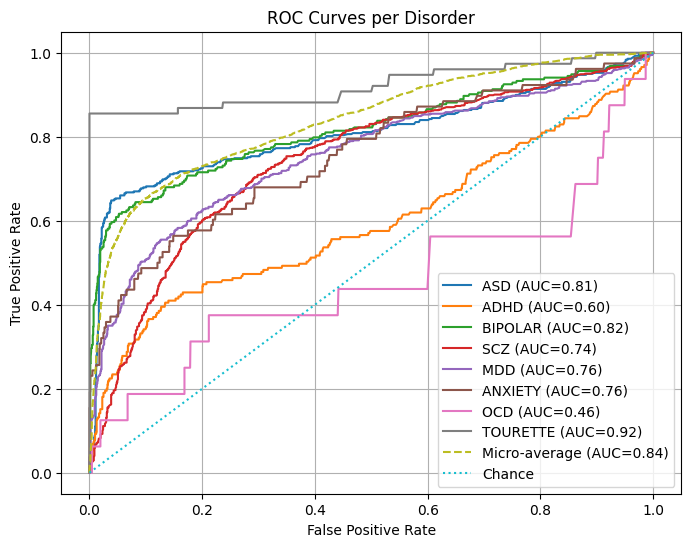

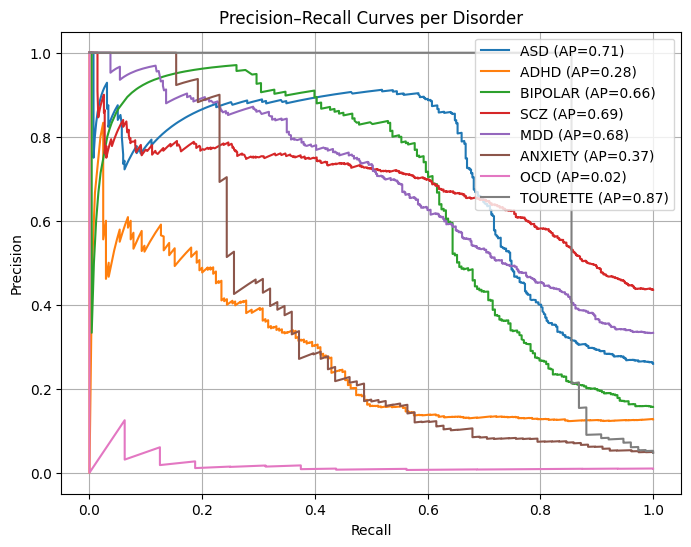

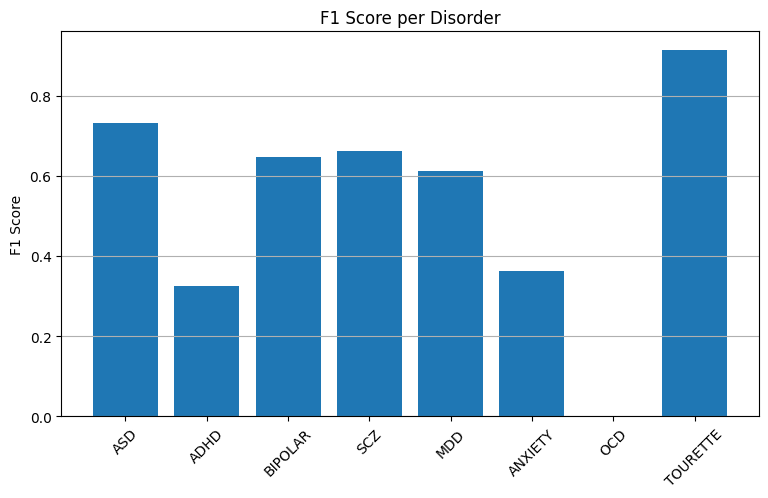

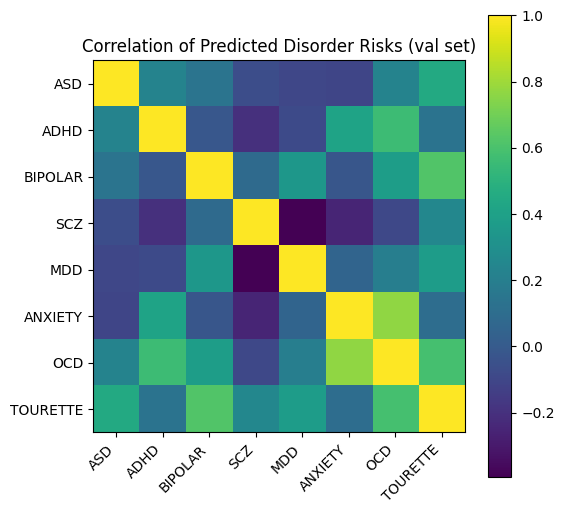

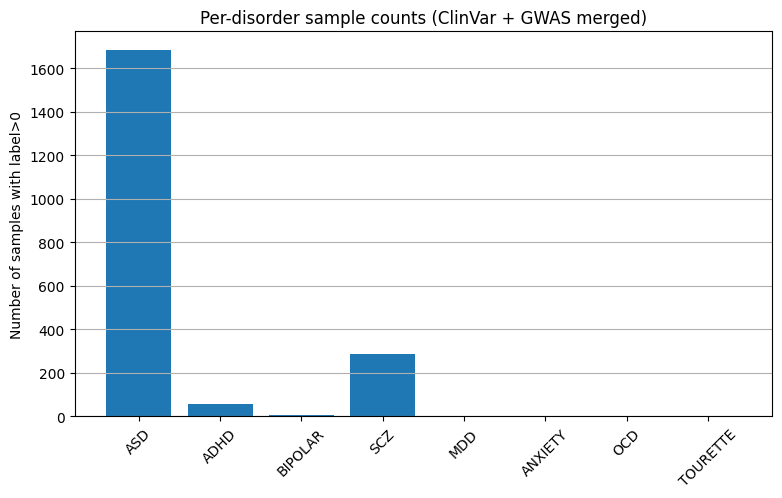

In [ ]:
# -------------------------
# SECTION 16 — VISUALIZATIONS
# -------------------------
print("\n--- VISUALIZATIONS ---")
disorder_names = final_disorders
num_disorders = len(disorder_names)

# 1) ROC curves (per disorder + micro)
plt.figure(figsize=(8, 6))
micro_fpr = None
micro_tpr = None
micro_auc = None
for i, d in enumerate(disorder_names):
    if metrics[d]["AUROC"] is not None:
        fpr, tpr, _ = roc_curve(true[:, i], probs[:, i])
        roc_auc = metrics[d]["AUROC"]
        plt.plot(fpr, tpr, label=f"{d} (AUC={roc_auc:.2f})")
# micro
try:
    fpr_micro, tpr_micro, _ = roc_curve(true.ravel(), probs.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, linestyle="--", label=f"Micro-average (AUC={auc_micro:.2f})")
except Exception:
    pass
plt.plot([0,1], [0,1], linestyle=":", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Disorder")
plt.legend()
plt.grid(True)
plt.show()

# 2) Precision-Recall curves
plt.figure(figsize=(8,6))
for i, d in enumerate(disorder_names):
    prec, rec, _ = precision_recall_curve(true[:, i], probs[:, i])
    ap = metrics[d]["AP"]
    plt.plot(rec, prec, label=f"{d} (AP={ap:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves per Disorder")
plt.legend()
plt.grid(True)
plt.show()

# 3) F1 barplot
f1_vals = [metrics[d]["F1"] for d in disorder_names]
plt.figure(figsize=(9,5))
plt.bar(disorder_names, f1_vals)
plt.ylabel("F1 Score")
plt.title("F1 Score per Disorder")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

# 4) Correlation heatmap of predicted risks
corr = np.corrcoef(probs.T)
fig, ax = plt.subplots(figsize=(6,6))
cax = ax.imshow(corr, aspect='equal')
ax.set_xticks(np.arange(num_disorders))
ax.set_yticks(np.arange(num_disorders))
ax.set_xticklabels(disorder_names, rotation=45, ha="right")
ax.set_yticklabels(disorder_names)
fig.colorbar(cax)
plt.title("Correlation of Predicted Disorder Risks (val set)")
plt.show()

# 5) Dataset distribution barplot (post-GWAS merge)
plt.figure(figsize=(9,5))
counts = [(df[f"LABEL_{d}"] > 0).sum() for d in disorder_names]
plt.bar(disorder_names, counts)
plt.ylabel("Number of samples with label>0")
plt.title("Per-disorder sample counts (ClinVar + GWAS merged)")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()


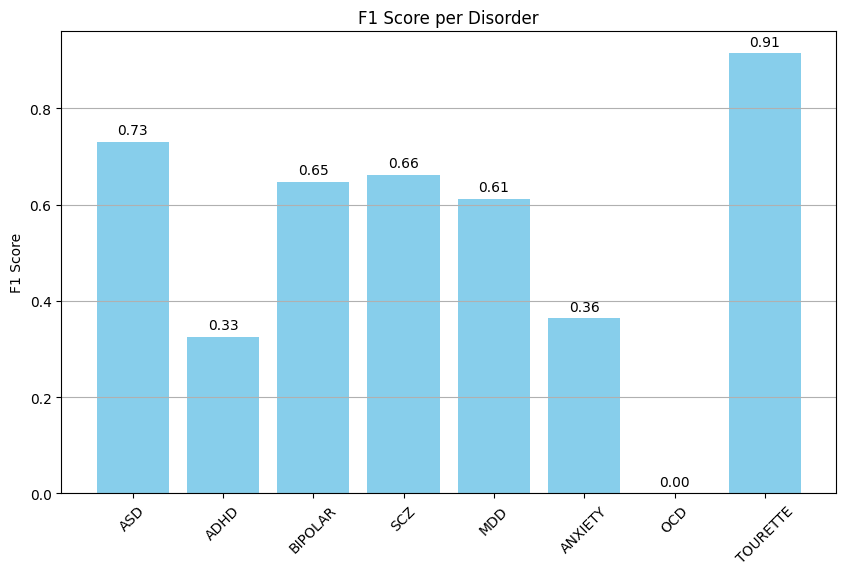

In [ ]:
plt.figure(figsize=(10,6))
bars = plt.bar(disorder_names, f1_vals, color="skyblue")  # raw F1 as height
plt.ylabel("F1 Score")
plt.title("F1 Score per Disorder")
plt.xticks(rotation=45)
plt.grid(axis="y")

# Annotate F1 values
for i, b in enumerate(bars):
    plt.text(b.get_x() + b.get_width()/2, b.get_height() + 0.01, f"{f1_vals[i]:.2f}",
             ha="center", va="bottom", fontsize=10)

plt.show()
